# Notes 2/6/23

**Goal:** We want to undestand why power increases for small values of $\sigma_G^2$ and increases for larger values.

In [1]:
from scipy.special import erfinv
from scipy.stats import gamma
import sys
import math
sys.path.insert(1,'numerics_snakemake')
from plot_sfs import *
from power_v2 import *
import matplotlib.cm as cm
import matplotlib as mpl

In [4]:
data = pd.read_csv("numerics_snakemake/spatial_integrals_dim2.csv")
data_pr = pd.read_csv("numerics_snakemake/cleaned_data_dim2_errorFalse.csv")
data_pr = data_pr.loc[data_pr['poly_type'] == '1_1']

sigma_vals = data['sigma'].tolist()
kappa_list = data['u2_GQ'].tolist()
res_vals = data_pr['residues']
pole_vals = data_pr['poles']

First, we plot power over $\sigma$, the sampling width. Power is defined as:
$$1-\int_0^{X*}g(x)dx$$
for
$$X^*=\frac{1}{2}-\frac{1}{2}\sqrt{1-\frac{2v_*(V_P/n)}{\beta_\ell^2}}$$
and $g(x)$ the sample SFS, with all terms computed as described previously.

We see in the below plot that for small values of $\sigma_G^2$, power increases (slightly) with $\sigma$, whereas for larger values of $\sigma_G^2$, power decreases with $\sigma$. 

For reference, two of the functions to calculate power ( `power_all_zs` returns threshold $X^*$ and power, in that order):

In [22]:
def power(zs, sigma, s, sigma_vals, res_vals, pole_vals, Nval=10000):
    beta = rate_p(sigma,s,sigma_vals,pole_vals,N=Nval)
    alpha = shape_p(sigma,s,sigma_vals,res_vals,N=Nval)
    return(gamma.sf(zs,a=alpha,scale=1/beta)) # sf = 1 - cdf

def power_all_zs(sigma,s,sigma_vals,kappa_list,
              res_vals,pole_vals,
              sigma2R=0.1,sigma2G=1.0,Nval=10000,n=1e6,a=1e-8,L=10000,mu=1e-8,d=2,D=1,l=1,sel_grad=1.0):
    Vg=calc_V_G(kappa_list,s,sel_grad,N=Nval,L=L,mu=mu,d=d,D=D)[sigma_vals.index(sigma)]
    Ve=calc_V_E(sigma,sigma2R,sigma2G,l,d)
    Vp=Vg+Ve
    zs=get_zs(s,sel_grad=sel_grad,Vp=Vp,n=n,a=a)
    power_val = power(zs,sigma,s,sigma_vals,res_vals,pole_vals,Nval)
    return zs, power_val

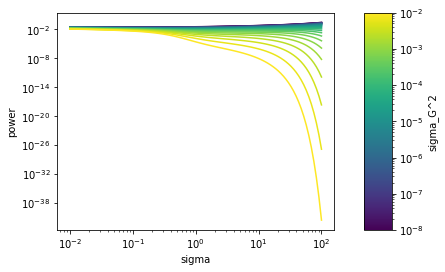

In [23]:
sigma2G_list = np.logspace(-8, -2,30)
fig, axs = plt.subplots(1, 2,gridspec_kw={'width_ratios': [10, 1]})
colors = plt.cm.viridis(np.linspace(0, 1, 30))
norm = mpl.colors.LogNorm(vmin=min(sigma2G_list), vmax=max(sigma2G_list))
for i in range(30):
    axs[0].plot(sigma_vals,[power_all_zs(sg, 0.01, sigma_vals, kappa_list, res_vals, pole_vals, sigma2G=sigma2G_list[i],
                      sigma2R=0)[1]
            for sg in sigma_vals],color=colors[i])

axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlabel("sigma")
axs[0].set_ylabel("power")
cb1 = mpl.colorbar.ColorbarBase(axs[1], cmap=mpl.cm.viridis,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('sigma_G^2')
plt.show()

By the above definition, power is equivalenty a survival function on $X^*$. As such, by construction, power should decrease as $X^*$ increases. We see below that $X^*$ increases with $\sigma$:

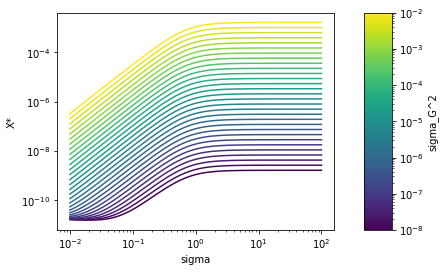

In [24]:
sigma2G_list = np.logspace(-8, -2, 30)
fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [10, 1]})
colors = plt.cm.viridis(np.linspace(0, 1, 30))
norm = mpl.colors.LogNorm(vmin=min(sigma2G_list), vmax=max(sigma2G_list))
for i in range(30):
    axs[0].plot(sigma_vals,
                [power_all_zs(sg, 0.01, sigma_vals, kappa_list, res_vals, pole_vals, sigma2G=sigma2G_list[i],
                           sigma2R=0)[0]
                 for sg in sigma_vals], color=colors[i])

axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlabel("sigma")
axs[0].set_ylabel("X*")
cb1 = mpl.colorbar.ColorbarBase(axs[1], cmap=mpl.cm.viridis,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('sigma_G^2')
plt.show()

This suggests that power should decline with $\sigma$ (i.e. increasing $\sigma$ $\implies$ increasing $X^*$ $\implies$ decreasing power). So, why do we see cases where the opposite occurs?

(Note: the nonlinear form of the $X^*$ vs. $\sigma$ curve may explain the "wavy" shape of the power curves.)

As a check, plot power vs. $X^*$, since power should (by construction) decrease with increasing $X^*$:

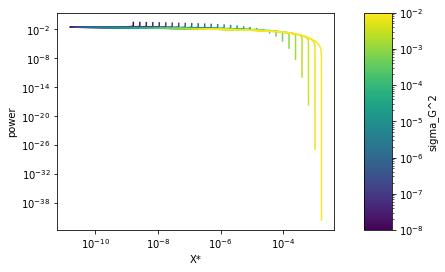

In [25]:
sigma2G_list = np.logspace(-8, -2, 30)
fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [10, 1]})
colors = plt.cm.viridis(np.linspace(0, 1, 30))
norm = mpl.colors.LogNorm(vmin=min(sigma2G_list), vmax=max(sigma2G_list))
for i in range(30): # note that zs in code is X^* in this notation
    axs[0].plot([power_all_zs(sg, 0.01, sigma_vals, kappa_list, res_vals, pole_vals, sigma2G=sigma2G_list[i],
                           sigma2R=0)[0]
                 for sg in sigma_vals], 
                [power_all_zs(sg, 0.01, sigma_vals, kappa_list, res_vals, pole_vals, sigma2G=sigma2G_list[i],
                           sigma2R=0)[1]
                 for sg in sigma_vals], color=colors[i])

axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlabel("X*")
axs[0].set_ylabel("power")
cb1 = mpl.colorbar.ColorbarBase(axs[1], cmap=mpl.cm.viridis,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('sigma_G^2')
plt.show()

Something appears to be going wrong here for the smaller values of $\sigma_G^2$. Plotting one value at a time, we see that for relatively large values of $\sigma_2^G$ power decreases in $X^*$, as expected:

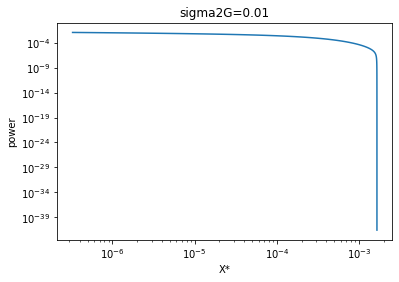

In [32]:
sigma2G = 1e-2
fig, axs = plt.subplots(1, 1)
axs.plot([power_all_zs(sg, 0.01, sigma_vals, kappa_list, res_vals, pole_vals, sigma2G=sigma2G,
                          sigma2R=0)[0]
             for sg in sigma_vals],
            [power_all_zs(sg, 0.01, sigma_vals, kappa_list, res_vals, pole_vals, sigma2G=sigma2G,
                          sigma2R=0)[1]
             for sg in sigma_vals])
axs.set_xscale("log")
axs.set_yscale("log")
axs.set_xlabel("X*")
axs.set_ylabel("power")
axs.set_title("sigma2G="+str(sigma2G))
plt.show()

Note: the range for $X^*$ in these plots is the range that is covered by the values of $\sigma$ used in the first plot.

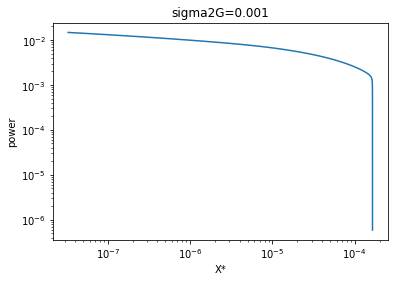

In [33]:
sigma2G = 1e-3
fig, axs = plt.subplots(1, 1)
axs.plot([power_all_zs(sg, 0.01, sigma_vals, kappa_list, res_vals, pole_vals, sigma2G=sigma2G,
                          sigma2R=0)[0]
             for sg in sigma_vals],
            [power_all_zs(sg, 0.01, sigma_vals, kappa_list, res_vals, pole_vals, sigma2G=sigma2G,
                          sigma2R=0)[1]
             for sg in sigma_vals])
axs.set_xscale("log")
axs.set_yscale("log")
axs.set_xlabel("X*")
axs.set_ylabel("power")
axs.set_title("sigma2G="+str(sigma2G))
plt.show()

However, this breaks as we decrease $\sigma_2^G$:

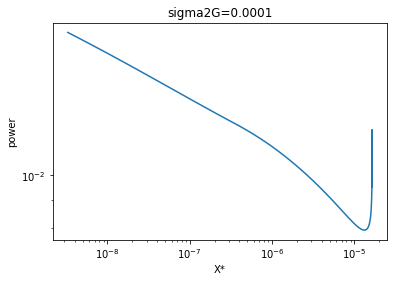

In [34]:
sigma2G = 1e-4
fig, axs = plt.subplots(1, 1)
axs.plot([power_all_zs(sg, 0.01, sigma_vals, kappa_list, res_vals, pole_vals, sigma2G=sigma2G,
                          sigma2R=0)[0]
             for sg in sigma_vals],
            [power_all_zs(sg, 0.01, sigma_vals, kappa_list, res_vals, pole_vals, sigma2G=sigma2G,
                          sigma2R=0)[1]
             for sg in sigma_vals])
axs.set_xscale("log")
axs.set_yscale("log")
axs.set_xlabel("X*")
axs.set_ylabel("power")
axs.set_title("sigma2G="+str(sigma2G))
plt.show()

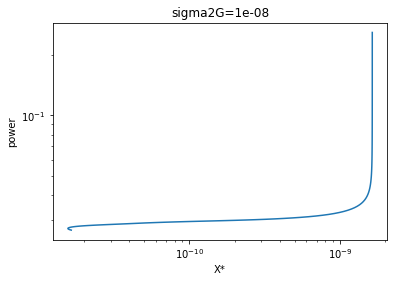

In [35]:
sigma2G = 1e-8
fig, axs = plt.subplots(1, 1)
axs.plot([power_all_zs(sg, 0.01, sigma_vals, kappa_list, res_vals, pole_vals, sigma2G=sigma2G,
                          sigma2R=0)[0]
             for sg in sigma_vals],
            [power_all_zs(sg, 0.01, sigma_vals, kappa_list, res_vals, pole_vals, sigma2G=sigma2G,
                          sigma2R=0)[1]
             for sg in sigma_vals])
axs.set_xscale("log")
axs.set_yscale("log")
axs.set_xlabel("X*")
axs.set_ylabel("power")
axs.set_title("sigma2G="+str(sigma2G))
plt.show()

So, it looks like the `sf` function is giving incorrect results for small $\sigma_G^2$. Why could this be? 

* With small $\sigma_G^2$ there is also small $V_P$, meaning that $X^*$ is smaller. Does this cause numerical instabilities with the integration? (Uses `sf` function in scipy.)
* Note that the range of values for power in these plots is small - perhaps there is not a significant change over $\sigma$ or $X^*$ in these cases and what variation we see is due to numerical instability?

Note that if we recreate the first plot but with a range of $\sigma_2^G$ that avoids this behavior, we see that power declines in $\sigma$ as expected across all values:

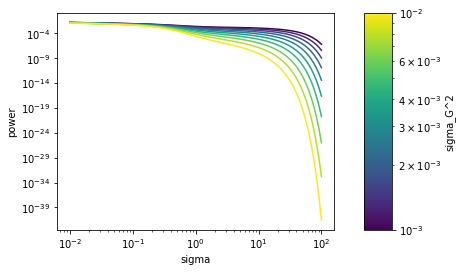

In [39]:
sigma2G_list = np.logspace(-3, -2,10)
fig, axs = plt.subplots(1, 2,gridspec_kw={'width_ratios': [10, 1]})
colors = plt.cm.viridis(np.linspace(0, 1, 10))
norm = mpl.colors.LogNorm(vmin=min(sigma2G_list), vmax=max(sigma2G_list))
for i in range(10):
    axs[0].plot(sigma_vals,[power_all_zs(sg, 0.01, sigma_vals, kappa_list, res_vals, pole_vals, sigma2G=sigma2G_list[i],
                      sigma2R=0)[1]
            for sg in sigma_vals],color=colors[i])

axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlabel("sigma")
axs[0].set_ylabel("power")
cb1 = mpl.colorbar.ColorbarBase(axs[1], cmap=mpl.cm.viridis,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('sigma_G^2')
plt.show()

(Power decreases as a function of $\sigma$, but not as a "clean" curve due to the sigmoid-esque shape of the $\sigma$ vs. $X^* relationship.)

In summary:
* Power should (by construction) decline with increasing $\sigma$ because it is defined as a survival function (1-CDF) over the threshold value $X^*$, which increases as $\sigma$ increases. 
* The reason that we see some increasing curves for small values of $\sigma_G^2$ is possibly numerical instability. (?)
* The reason the curves are a bit "wavy" (for lack of better technical term) is possibly due to the nonlinear relationship between $\sigma$ and $X^*$. 

Next steps:
* Can we show why the numerical calculations start to break down for small $\sigma_G^2$? (Or, more generally, small $V_P$?)

Extra: with this range of $\sigma_G^2$ there is a general decrease in power with more geographic variation in broad samples, which makes sense. Or, for smaller $\sigma$, power is close to flat (also makes sense - closer to point sampling, geographic process less informative).

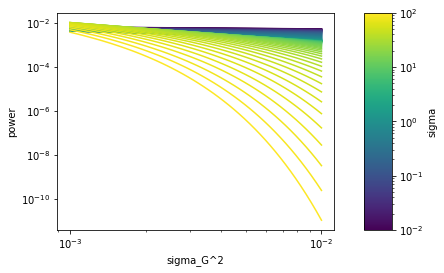

In [41]:
sigma2G_list = np.logspace(-3, -2)
fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [10, 1]})
colors = plt.cm.viridis(np.linspace(0, 1, len(sigma_vals)))
norm = mpl.colors.LogNorm(vmin=min(sigma_vals), vmax=max(sigma_vals))
for i in range(len(sigma_vals)):
    axs[0].plot(sigma2G_list,
            [power_all(sigma_vals[i], 0.1, sigma_vals, kappa_list, res_vals, pole_vals, sigma2G=s2g, sigma2R=1e-8) for s2g
             in sigma2G_list],color=colors[i])
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlabel("sigma_G^2")
axs[0].set_ylabel("power")
cb1 = mpl.colorbar.ColorbarBase(axs[1], cmap=mpl.cm.viridis,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('sigma')
plt.show()